# KNN for Netflix Prize Data

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.neighbors import NearestNeighbors
from math import sqrt
from sklearn.metrics import mean_squared_error

In [178]:
movie_title = pd.read_csv("/Users/xjshen/Downloads/movie_titles.csv", encoding='unicode_escape', usecols=[2], header=None)
movie_title.columns = ['title']
movie_title

,title
0,Dinosaur Planet
1,Isle of Man TT 2004 Review
2,Character
3,Paula Abdul's Get Up & Dance
4,The Rise and Fall of ECW
...,...
17765,Where the Wild Things Are and Other Maurice Se...
17766,Fidel Castro: American Experience
17767,Epoch
17768,The Company


In [3]:
cwd = os.getcwd()
data = pd.read_csv("/Users/xjshen/data/final.csv")
data.describe()

,MovieID,CustomerID,Rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


In [4]:
data.head()

,MovieID,CustomerID,Rating,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


<AxesSubplot:>

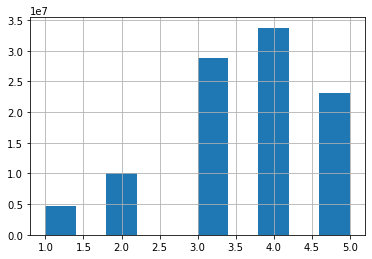

In [5]:
data['Rating'].hist()

In [6]:
user_count = data.CustomerID.nunique(dropna = True)
movie_count = data.MovieID.nunique(dropna = True)
print("number of unique user:", user_count)
print("-"*40)
print("number of unique movies:", movie_count)

number of unique user: 480189
----------------------------------------
number of unique movies: 17770


In [7]:
# checking sparsity of this dataset
total_rating = user_count*movie_count
rating_not_0 = len(data['Rating'].tolist())
ratings_0 = total_rating - rating_not_0

print("sparsity of this dataset is", ratings_0 / total_rating)

sparsity of this dataset is 0.9882244233759331


In [8]:
movie_freq = pd.DataFrame(data.groupby('MovieID').size(),columns=['count'])
movie_freq.head()

,count
MovieID,
1,547
2,145
3,2012
4,142
5,1140


Text(0, 0.5, 'Rating frequency of movies')

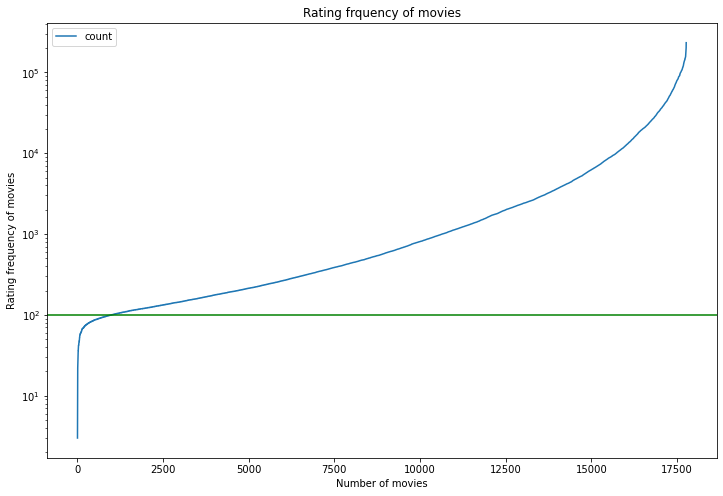

In [9]:
# plot movie rating frequency
movie_freq_1 = movie_freq.sort_values(by='count').reset_index(drop=True)

ax  = movie_freq_1.plot(
    title='Rating frquency of movies',
    figsize=(12,8),
    logy=True
)
ax.axhline(100, color ='green') 
ax.set_xlabel('Number of movies')
ax.set_ylabel('Rating frequency of movies')

In [10]:
# A few movies are rated very rarely, so we can remove those movies which are rated less than 100 times.

threshold = 100

popular_movies = list(set(movie_freq.query('count>=@threshold').index))

# ratings df after dropping non popular movies
data_popular_movies = data[data.MovieID.isin(popular_movies)]

print('shape of original data:', data.shape)
print('shape of data_popular_movies', data_popular_movies.shape)
print("No. of movies which are rated more than 100 times:", len(popular_movies))

shape of original data: (100480507, 4)
shape of data_popular_movies (100400918, 4)
No. of movies which are rated more than 100 times: 16795


In [11]:
user_freq = pd.DataFrame(data.groupby('CustomerID').size(),columns=['count'])
user_freq.head()

,count
CustomerID,
6,626
7,881
8,98
10,260
25,27


Text(0, 0.5, 'Rating frequency of users')

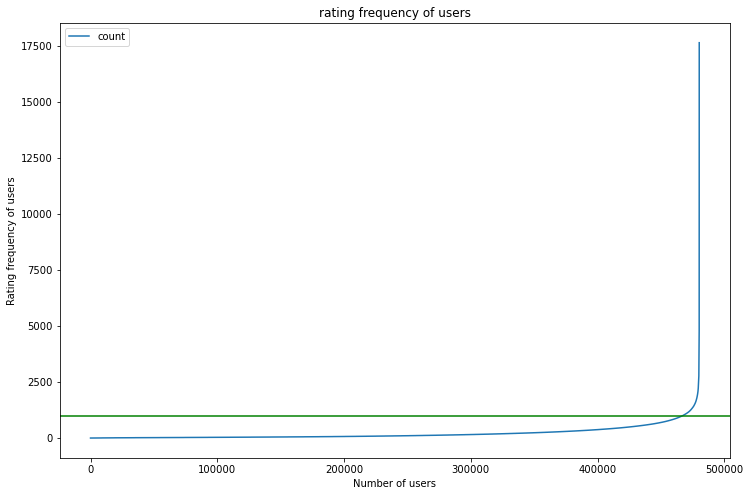

In [12]:
# plot user's rating freq
ax  = user_freq.sort_values('count').reset_index(drop=True).plot(
      title='rating frequency of users',
      figsize=(12,8))
ax.axhline(1000, color ='green') 
ax.set_xlabel("Number of users")
ax.set_ylabel("Rating frequency of users")

In [13]:
# A large number of users are rated very rarely, so we can remove those users which are rated less than 1000 times.
threshold = 1000
active_user = list(set(user_freq.query('count>=@threshold').index))
data_popular_movies_active_user = data_popular_movies[data_popular_movies.CustomerID.isin(active_user)]

print('shape of original data:', data.shape)
print('shape of data_popular_movies', data_popular_movies.shape)
print('shape of data_popular_movies_active_user', data_popular_movies_active_user.shape)
print('No. of users who rated more than 1000 times:', len(active_user))

print('user number of new matrix', len(active_user))
print('movie number of new matrix', len(popular_movies))

shape of original data: (100480507, 4)
shape of data_popular_movies (100400918, 4)
shape of data_popular_movies_active_user (18757426, 4)
No. of users who rated more than 1000 times: 13141
user number of new matrix 13141
movie number of new matrix 16795


In [14]:
data_popular_movies_active_user

,MovieID,CustomerID,Rating,Date
0,1,1488844,3,2005-09-06
3,1,30878,4,2005-12-26
7,1,1248029,3,2004-04-22
19,1,372233,5,2005-11-23
20,1,1080361,3,2005-03-28
...,...,...,...,...
100480501,17770,311124,3,2005-09-29
100480502,17770,1790158,4,2005-11-01
100480504,17770,234275,1,2004-08-07
100480505,17770,255278,4,2004-05-28


In [15]:
# Calculating sparsity of new matrix
total_ratings = len(active_user)*len(popular_movies)
rating_not_0 = len(data_popular_movies_active_user['Rating'].tolist())
ratings_0 = total_ratings - rating_not_0

print("sparsity of new user-item matrix is ", ratings_0 / total_ratings)


sparsity of new user-item matrix is  0.9150105892262181


## item based recommender

In [16]:
# pivot data to movie-users matrix
movie_users_df = data_popular_movies_active_user.pivot(index='MovieID',columns = 'CustomerID',values='Rating').fillna(0)
movie_users_df

CustomerID,769,1333,1442,2213,2455,2469,2787,2905,2976,3321,...,2647871,2647888,2648287,2648465,2648502,2648589,2648734,2648869,2648885,2649285
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17767,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17768,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


make_recommendation('Dinosaur Planet',movie_users_df_sparse,knn,movie_to_index,10)

In [179]:
# create a sparse matrix for efficient calculations
from scipy.sparse import csr_matrix
movie_users_df_sparse = csr_matrix(movie_users_df.values)

In [180]:
# define the model
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine',algorithm = 'brute', n_neighbors=20)

In [197]:
# create a function which takes a movie name and make recommedation for it
def make_recommendation(input_str,data,model,n_recommendation):
    model.fit(data)
    index = movie_title[movie_title['title']==input_str].index.values
    if (index.size == 0) ==True:
        print("pls enter a valid movie name\n")
        return 
    index_list = (model.kneighbors(data[index],n_neighbors=n_recommendation+1,return_distance=False)).tolist()
    print("Viewer who watches this movie ",input_str,"also watches following movies.")
    for i in index_list[0][1:]:
        new_index = movie_users_df.iloc[[i]].index.values - 1
        res = movie_title.loc[new_index]['title'].values.tolist()[0]
        print(res)

    return

In [198]:
make_recommendation('Dinosaur Planet',movie_users_df_sparse,knn,10)

[[0, 654, 4990, 3948, 1026, 12812, 9663, 1110, 8283, 14250, 9887]]
Viewer who watches this movie  Dinosaur Planet also watches following movies.
When Dinosaurs Roamed America
Chased by Dinosaurs: Three Walking with Dinosaurs Adventures
Walking with Cavemen
Walking with Prehistoric Beasts
Allosaurus: A Walking with Dinosaurs Special
Prehistoric Planet: The Complete Dino Dynasty
Walking with Dinosaurs
Prehistoric America: A Journey Through the Ice Age and Beyond
Before We Ruled the Earth: Hunt or Be Hunted
Land of the Mammoth


# user based recommender

In [201]:
# pivot data to user-movie matrix
user_movie_df = data_popular_movies_active_user.pivot(index='CustomerID',columns ='MovieID' ,values='Rating').fillna(0)
user_movie_df

MovieID,1,2,3,4,5,6,8,10,11,12,...,17761,17762,17763,17764,17765,17766,17767,17768,17769,17770
CustomerID,,,,,,,,,,,,,,,,,,,,,
769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1333,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,4.0,3.0,1.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0
1442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,4.0
2455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2648734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2648869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
# create a sparse matrix for efficient calculations
from scipy.sparse import csr_matrix
user_movie_df_sparse = csr_matrix(user_movie_df.values)

In [ ]:
# define the model
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine',algorithm = 'brute', n_neighbors=20)

In [297]:
# create a function which takes a movie name and make recommedation for it
recommendation = {}
def make_recommendation(input_user,data,model,n_recommendation):
    
    if input_user not in user_movie_df.index:
        print("pls enter a valid user number\n")
        return 
    model.fit(data)
    similar_users_list = (model.kneighbors(data[input_user],n_neighbors=n_recommendation+1,return_distance=False)).tolist()
    for i in similar_users_list[0][1:]:
        for j in user_movie_df.columns:
            ratingLst = []
            if user_movie_df.iloc[input_user][j] == 0 and user_movie_df.iloc[i][j] > 4:
                if j not in recommendation:
                    ratingLst.append(user_movie_df.iloc[i][j])
                    recommendation[j] = ratingLst
                else:
                    recommendation.get(j).append(user_movie_df.iloc[i][j])
    print("Viewer", input_user, "who will like following movies.")
    number = 0
    for k in sorted(recommendation, key=lambda k: len(recommendation[k]), reverse=True):
        if number < 10:
            res = movie_title.loc[k-1]['title']
            print(res)
            number += 1 #recommend top 10 movies
        

In [298]:
make_recommendation(769,user_movie_df_sparse,knn,10)

Viewer 769 who will like following movies.
Apocalypse Now Redux
The Blues Brothers: Extended Cut
Predator: Collector's Edition
Scarface: 20th Anniversary Edition
Kill Bill: Vol. 1
American Beauty
Eternal Sunshine of the Spotless Mind
Grosse Pointe Blank
Raging Bull
Easy Rider


In [ ]:
user_movie_df = user_movie_df.to_numpy()

mapping movie index and its title
movie_to_index = { movie:i for i,movie in enumerate(list(movie_title_title.set_index('index').loc[movie_users_df.index].title)) } movie_to_index

create a sparse matrix for efficient calculations
from scipy.sparse import csr_matrix movie_users_df_sparse = csr_matrix(movie_users_df.values)

fuzzy_movie_name_matching
from fuzzywuzzy import fuzz

def fuzzy_movie_name_matching (input_str,mapper,print_matches): # match_movie is list of tuple of 3 values(movie_name,index,fuzz_ratio) match_movie = [] for movie,ind in mapper.items(): current_ratio = fuzz.ratio(movie.lower(),input_str.lower()) if(current_ratio>=50): match_movie.append((movie,ind,current_ratio))

# sort the match_movie with respect to ratio 

match_movie = sorted(match_movie,key =lambda x:x[2])[::-1]

if len(match_movie)==0:
    print("No movie finded\n")
    return -1
if print_matches == True:
    print("some matching of input_str are\n")
    for title,ind,ratio in match_movie:
        print(title,ind,'\n')

return match_movie[0][1]  #find index of the movie
define the model
from sklearn.neighbors import NearestNeighbors knn = NearestNeighbors(metric='cosine',algorithm = 'brute', n_neighbors=20)

create a function which takes a movie name and make recommedation for it
def make_recommendation(input_str,data,model,mapper,n_recommendation): model.fit(data) index = fuzzy_movie_name_matching (input_str,mapper,print_matches = False) print('index', index) if index==-1 : print("pls enter a valid movie name\n") return

index_list = model.kneighbors(data[index],n_neighbors=n_recommendation+1,return_distance=False)
print('index_list',index_list)
# now we ind of all recommendation
# build mapper index->title
index_to_movie={
    ind:movie for movie,ind in mapper.items()
}

print("Viewer who watches this movie ",input_str,"also watches following movies.")
for i in range(1,index_list.shape[1]):
    print(index_to_movie[index_list[0][i]])

return
make_recommendation('Dinosaur Planet',movie_users_df_sparse,knn,movie_to_index,10)